__[A Baby Robot's Guide To Reinforcement Learning](https://towardsdatascience.com/tagged/baby-robot-guide)__

# Monte Carlo Methods
## An Introduction to Reinforcement Learning: Part 4

<center><img src="images/part4/monte_carlo_gpi_visits_10x7_opt.gif"/></center>

# Introduction

Once again we're off to the casino, and this time it's situated in sunny Monte Carlo, made famous by its appearance in the classic movie _[Madagascar 3: Europe's Most Wanted](https://en.wikipedia.org/wiki/Madagascar_3:_Europe%27s_Most_Wanted)_ (although there's a slight chance that it was already famous).

In our last visit to a casino we looked at the _[multi-armed bandit](https://medium.com/towards-data-science/multi-armed-bandits-part-1-b8d33ab80697)_ and used this as a way to visualise the problem of how to choose the best action when confronted with many possible actions.

In terms of **Reinforcement Learning** the bandit problem can be thought of as representing a single state and the actions available within that state. _Monte Carlo_ methods extend this idea to cover multiple, interrelated, states.

Additionally, in the previous problems we've looked at, we've always been given a full model of the environment. This model defines both the transition probabilities, that describe the chances of moving from one state to the next, and the reward received for making this transition.

In _Monte Carlo_ methods this isn't the case. No model is given and instead the agent must discover the properties of the environment through exploration, gathering information as it moves from one state to the next. In other words, <i>Monte Carlo methods learn from experience.</i>

<center><img src="images/green_babyrobot_small.gif"/></center>

___

This notebook accompanies the Towards Data Science article and is part of _[A Baby Robot's Guide To Reinforcement Learning](https://towardsdatascience.com/tagged/baby-robot-guide)_


To interactively run this notebook try opening it on Binder:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/WhatIThinkAbout/BabyRobot/HEAD?labpath=%2FReinforcement_Learning%2FPart%204%20-%20Monte%20Carlo%20Methods.ipynb)

___

# Code Setup

The examples in this notebook use the **[Baby Robot Custom Gym Environment](https://medium.com/towards-data-science/creating-a-custom-gym-environment-for-jupyter-notebooks-e17024474617)**.

The source code for this can be found on _[Github](https://github.com/WhatIThinkAbout/BabyRobotGym)_


In [1]:
# install Baby Robot Gym
# %pip install --upgrade babyrobot -q

In [1]:
import babyrobot
print(f"Baby Robot Version = {babyrobot.__version__}")

Baby Robot Version = 1.0.40


In [61]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy
from IPython.display import Image as PyImage

from babyrobot.envs.lib import Actions
from babyrobot.lib import Policy
from babyrobot.lib import PolicyEvaluation
from babyrobot.lib import Animate
from babyrobot.lib import MonteCarloGPI

# Monte Carlo Prediction

In the prediction problem we want to find how good it is to be in a particular state of the environment. This "_goodness_" is represented by the state value, which is defined as the expected reward that can be obtained when starting in that state and then following the current policy for all subsequent states.

When we have full knowledge about the environment, and know the transition probabilities and rewards, we can simply use _[Dynamic Programming](https://medium.com/towards-data-science/state-values-and-policy-evaluation-ceefdd8c2369#e996)_ to iteratively calculate the value for each state.

In practice, its unlikely that a system's transition probabilities are known in advance. Therefore, to estimate how likely it is to move from one state to another, it's possible to observe multiple episodes and then take the average. This approach, of taking random samples to calculate estimates, is known as **_Monte Carlo Sampling_**.


Consider the level, shown in figure 1 below, where Baby Robot currently finds himself:

<br><br>
<center><img src="images/part4/glass_wall_level.png"/></center>
<center><i>Figure 1: A level containing a glass wall and the co-ordinates on this level.</i></center>

At first glance this level appears to be rather simple, with a short path from the start of the level to the exit. However, there are 2 obstacles of note:

* In the top-middle square (coordinate (1,0)) there is a large puddle. As we've seen before, Baby Robot doesn't like puddles. They take longer to move through, incurring a negative reward of -4, and can cause him to skid.\
\
When a skid occurs Baby Robot won't reach the target state. Normally this would result in him moving to one of the other possible states, but in this case there are no other possible states, so he'll stay exactly where he is and receive another -4 penalty.\
\
If Baby Robot moves into this puddle there's a good chance he'll become stuck for several time periods and receive a large negative reward. It would be best to avoid this puddle!
<br>
<br>


* The thick blue line, between the cells (1,1) and (1,2), represents a glass wall. This is a new type of challenge that Baby Robot hasn't encountered before.\
\
Unlike standard walls, Baby Robot can't see glass walls and may therefore select an action that causes him to walk into the wall. When this happens he'll bounce off the wall and, rather than reaching the target state, end up in the opposite state. Also, he'll be given a negative reward penalty of -1 for the additional time required to make the move.\
\
In this level there are 2 possible opportunities for walking into the glass wall:

  - if he moves South from cell (1,1) he'll instead end up in the puddle at (1,0) and receive a reward of -5 (-4 for moving into a puddle and -1 for hitting the glass wall).

  - if he moves North from (1,2), instead of arriving at (1,1) he'll actually bounce off the wall and end up at the exit. In this case he'll be given a reward of -2 (-1 wall penalty and -1 for moving to a dry square).

### Code Example

The code below sets up and displays the example level, shown in Figure 1 above.

In [3]:
# create the environment
basesetup = {'width':3,'height':4,'start':[0,1],'end': [1,3]}

# add a glass wall
basesetup['walls'] = [((1, 1),'S',{'color':'#00a9ff','width':10,'fit':True,'prob':0.0})]
basesetup['puddles'] = [((1,0),2)]   
basesetup['base_areas'] = [(0,0,1,1),(0,2,1,2),(2,0,1,1),(2,3,1,1)]

# use this if problems drawing puddles
# basesetup['drawmode'] = 'colab'

In [4]:
# create the test environment using the base setup
setup = deepcopy(basesetup)
env = babyrobot.make("BabyRobot-v0", **setup )
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

In [5]:
# create a setup for information display 
# - just show the graphical grid
info_setup = deepcopy(basesetup)
info_setup['show_start_text'] =False
info_setup['show_end_text'] = False
info_setup['robot'] = { 'show': False}

In [6]:
setup = deepcopy(info_setup)
setup['add_compass'] = True
env = babyrobot.make("BabyRobot-v0", **setup )
info = {'coords': True}
env.show_info(info)
env.render()

MultiCanvas(height=260, sync_image_data=True, width=296)

---
<br>

As mentioned above, when we have complete information about a system, and know all of its transition probabilities and rewards, we can use _[Policy Evaluation](https://towardsdatascience.com/state-values-and-policy-evaluation-ceefdd8c2369)_ to calculate the state values.

For this environment with a stochastic policy, that just chooses randomly between the available actions in each state, _Policy Evaluation_ gives the following state values:

In [7]:
# create a stochastic policy and a policy evaluation object for this policy
policy = Policy(env)
policy_evaluation = PolicyEvaluation( env, policy )

setup = deepcopy(info_setup)
env = babyrobot.make("BabyRobot-v0", render_mode=None, **setup)
steps_to_convergence = policy_evaluation.run_to_convergence(max_iterations = 1000)
print(f"Convergence in {steps_to_convergence} iterations")

# show the final state values after convergence
env = babyrobot.make("BabyRobot-v0",**setup)
info = {'text': policy_evaluation.end_values, 'precision': 2}
env.show_info(info) 
env.render()

Convergence in 323 iterations


MultiCanvas(height=260, sync_image_data=True, width=196)

<i>Figure 2: State values calculated using Policy Evaluation for a stochastic policy.</i>

Each of these state values represents the expected return from that state. So, at time '_t_' if we start in state '_s_' the value of a state under policy '_π_' is given by:

<br>
<center><img src="images/part4/equation1.png"/></center>
<center><i>Equation 1: The state value function under policy π</i></center>
<br>

Where the return '_Gₜ_', the total amount of reward accumulated over an episode, starting at time '_t_', is given by:

<br>
<center><img src="images/part4/equation1.png"/></center>
<center><i>Equation 2: The discount return at time 't'</i></center>
<br>


With a stochastic policy, for this simple level, we know that ultimately Baby Robot will reach the exit and the episode will terminate. Therefore we can set the discount factor '_γ_' to 1. Under these conditions the state value gives the average future total reward that can be expected when starting in that state.

In other words, the value of a state is the total of all future rewards obtained from that state, until completion of an episode, averaged over infinite episodes.

Therefore, to get a simple estimate of the state value, we can simply take the average return of multiple episodes that commence in that state. The more episodes we run the better our estimate will be. This is the exact approach taken by **_Monte Carlo methods_**.

In [8]:
from babyrobot.lib import Animate

# helper function to display text information in the side panel
def get_info_string( details ):
  info = {}
  info['side_info'] = \
  [
    ((14,110),f"Step: {details['step']}"),
    ((14,130),f"Action: {details['action']}"),
    ((14,150),f"New State: {details['new_state']}"),
    ((14,170),f"Total Reward: {details['total_reward']}"),
  ]
  return info

# try changing these values to create different, random, paths
seed = 1234
max_steps = 5

# create an environment with a stochastic policy
setup = deepcopy(basesetup)
setup['side_panel'] = {'width':150}
setup['add_compass'] = True
env = babyrobot.make("BabyRobot-v0",**setup)

# set the policy's random seed to create a reproducible trajectory
policy = Policy(env,seed=seed)
info = {'coords': True}
env.show_info(info)

# display default information about the episode
args = { 'max_steps': max_steps }
args['info_function'] = get_info_string
animate = Animate(env)
animate.show_policy(policy,**args)

<i>Figure 3: A sample episode with a trajectory that goes directly from the start state to the exit.</i>

For example, from the start state, if Baby Robot was lucky enough to follow a path that took him directly to the exit (as shown in _figure 3_ above), his trajectory would have the following states and rewards:

```
[([1,1], -1), ([2,1], -1), ([2,2], -1), ([1,2], -1), ([1,3], -1)]

The moves on this trajectory are:

[0,1]->[1,1] - reward = -1
[1,1]->[2,1] - reward = -1
[2,1]->[2,2] - reward = -1
[2,2]->[1,2] - reward = -1
[1,2]-> Exit - reward = -1
```

So, for this episode, the return value is -5. If we then ran the experiment again, with a stochastic policy that produces a different, random, path through the level, we'd get a different return value. By adding the returns from many such episodes and taking the average we'd get an estimate of the state value for the start state (0,1). The more episodes we run, the closer this estimate would be to the true state value.

For the initial state on this level, if we run multiple episodes and take the average return, we get an estimated state value of approximately -102, which is identical to the state value calculated using Policy Evaluation. 

However we've now calculated this state value purely by exploration, without knowing the model of the environment. Additionally, by following a random trajectory until termination of the episode, we've actually just performed our first **_Monte Carlo search_**.

> _To see this in action, try changing the 'seed' and 'max_steps' parameters in the code above._

## Calculating the return values for other states on the trajectory

In the above example we saw that, by repeatedly running episodes from the start state of the level, we could produce an estimate of the state value for that state. However, each episode passes through many states before finally reaching the terminal state. Yet, in the very simple Monte Carlo search that we've just described, we only considered the return values obtained from the start state and ignored all the other information gathered during the episode. This is very inefficient.

A better approach is to calculate the return value for every state that's seen during the episode. Then, over multiple random episodes, we can create an estimate for every state value that's been visited.

As you can see for the sample trajectory given above (_figure 3_), on his way to the exit Baby Robot also visits the states [1,1],[2,1],[2,2] and [1,2]. So, during this episode, we can also gather information for all of these states. For each state visited, we can consider the future rewards obtained from each state to be the return for that state. This then gives us an estimated return value for all states seen during the trajectory, not just the start state.

For this sample trajectory we get the following return values for the states that have been visited:

```
[0,1] - return = -5
[1,1] - return = -4
[2,1] - return = -3
[2,2] - return = -2
[1,2] - return = -1
```

If we then average these values over many episodes we'll get an increasingly accurate estimate of the state value for all states that have been visited.

# First-Visit Monte Carlo

When each state is visited only once during an episode, as in our example above, then it's easy to calculate the return for each state - you just add up all future rewards from that state. But what happens when a state is seen multiple times?

The simplest approach to calculate the value for a state that can be visited repeatedly in a single episode is to simply take the rewards obtained from the first time the state is visited until the end of the episode. When these returns are averaged over multiple episodes we can build up an estimate of the state value for every state that's been visited. Unsurprisingly, this approach is known as **_First-Visit Monte Carlo_**.


### Example:

One possible path from the entrance to the exit of the sample level is shown in _Figure 4_ below:
<br>

In [9]:
from babyrobot.lib import DeterministicPolicy

# create an environment with a deterministic policy
setup = deepcopy(basesetup)
setup['side_panel'] = {'width':150}
setup['add_compass'] = True
env = babyrobot.make("BabyRobot-v0",**setup)

# set the policy's actions to create a reproducible trajectory
actions = [Actions.East,Actions.East,Actions.South,Actions.North,Actions.South,Actions.West,Actions.South]    
policy = DeterministicPolicy(env,actions)  
info = {'coords': True}
env.show_info(info)

# display default information about the episode
args = { 'max_steps': 7 }
args['info_function'] = get_info_string
animate = Animate(env)
animate.show_policy(policy,**args)

<i>Figure 4: A trajectory with repeated state visits</i>

This path has the following steps and rewards:

```
1. [0,1]->[1,1] - reward = -1
2. [1,1]->[2,1] - reward = -1
3. [2,1]->[2,2] - reward = -1
4. [2,2]->[2,1] - reward = -1
5. [2,1]->[2,2] - reward = -1
6. [2,2]->[1,2] - reward = -1
7. [1,2]-> Exit - reward = -1
```

In this trajectory, rather than moving straight to the exit, on step 4 Baby Robot takes a step backwards to state [2,1]. After this he follows a direct path to the exit. As a result of this backwards step he visits states [2,1] and [2,2] twice.

With First-Visit Monte Carlo we sum the rewards obtained from the first time a state is seen until the end of the episode, to give an estimate of that state's value. When a state that's been seen before is re-visited, its reward is still used as part of the return, but we don't consider this to be a new trajectory from that state.

For this trajectory the first-visit return values are shown below. Note that we don't calculate returns from steps 5 and 6, for states that have already been seen:

```
1. [0,1] - return = -7
2. [1,1] - return = -6
3. [2,1] - return = -5
4. [2,2] - return = -4
5. [2,1]
6. [2,2]
7. [1,2] - return = -1
```

The steps of the method we've described above are detailed in the following Python Code, for the First-Visit Monte Carlo algorithm:

In [10]:
def rewards_to_returns(state_rewards):
  # work backwards to convert the rewards into returns  
  γ = 1.0
  G = 0
  state_returns = []
  for state, reward in reversed(state_rewards):
    G = reward + γ*G      
    state_returns.append((state,G))  

  # put back into the order of states visited
  state_returns.reverse()  
  return state_returns
  

def single_episode(env):
  # run a single episode to collect the reward at each state of the trajectory
  state,info = env.reset()
  state_rewards = []
  total_reward = 0
  terminated = False
  while not terminated:
    action = env.action_space.sample()
    new_state, reward, terminated, truncated, info = env.step(action)
    total_reward += reward
    state_rewards.append((state,reward))
    state = new_state
  return state_rewards


def get_first_visit_return(state_returns):
  # find the value of the first visit to a state  
  # V = np.zeros((env.height,env.width))
  V = np.tile(np.nan, (env.height,env.width))

  # the first time a state is seen store the return value
  for s, G in state_returns:    
    # test if this state hasn't yet been vistied (entry is still NaN)
    # convert from state's x,y coordinate to numpy row,col
    if np.isnan(V[s[1],s[0]]):
      V[s[1],s[0]] = G  

  # get the states that were visited by looking at those that aren't NaN
  visits = np.array( np.isnan(V)==False, dtype=int) 

  # replace all NaNs with zero to get the return at each state
  returns = np.nan_to_num(V, copy=False, nan=0.0 )    
  
  return returns, visits

In [11]:
def monte_carlo_first_visit(env, max_episodes = 1):

  # keep a count of the visits to each state
  visits = np.zeros((env.height,env.width))                                 # ❶

  # the total returns for each state
  returns = np.zeros((env.height,env.width))

  for episode in tqdm(range(max_episodes)):                                 # ❷

    state_rewards = single_episode(env)                                     # ❸
    state_returns = rewards_to_returns(state_rewards)                       # ❹
    episode_returns, episode_visits = get_first_visit_return(state_returns) # ❺

    # add the episode returns to the total returns
    returns += episode_returns

    # increment the count of any states that have been visited
    visits += episode_visits
  
  return np.divide(returns, visits, out=np.zeros_like(returns), where=visits!=0), visits  # ❻

<br>
<b>The points to note in the code above, for First-Visit Monte Carlo, are as follows:</b>

1. We want to keep track of the episode returns and number of visits to each state, therefore we start by creating zero'd Numpy arrays for each of these. The array dimensions are set to the width and height of the environment.

2. Run for multiple episodes to get the returns generated over multiple trajectories. Here the number of runs is defined by '_max_episodes_'.

3. Get the rewards for a single episode. This returns a list of all the states visited and the rewards received between the start and end of the episode.

4. Convert the rewards into returns. This is done by simply summing the rewards in reverse direction.

5. Take the first visit return value from the episode and add this value to the '_returns_' array. Additionally, for every state visited, we increment the count of the total number of visits to that state (i.e. we count only the number of first-visits).

6. Finally, after all episodes have completed, we divide the total first-visit rewards by the total number of visits, to get the average return for each state. \
Here we're using the Numpy divide function to avoid divide by zero errors for any states that have not been visited.

In [12]:
setup = deepcopy(info_setup)
env = babyrobot.make("BabyRobot-v0", render_mode=None, **setup)
state_values, visits = monte_carlo_first_visit(env,10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [13]:
# show the state values calculated using First-Visit MC
info_setup['side_panel'] = {'width':0}
env = babyrobot.make("BabyRobot-v0",**info_setup)
info = {'text': state_values, 'precision': 0}
env.show_info(info) 
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

In [14]:
env = babyrobot.make("BabyRobot-v0",**info_setup)
info = {'text': visits, 'precision': 0}
env.show_info(info) 
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

<center><img src="images/part4/mc_first_visit_state.png"/></center>
<center><i>Figure 5: First-Visit MC calculated state values and state first-visit count for 10000 episodes.</i></center>
<br>

The state values, calculated using First-Visit Monte Carlo, running for 10000 episodes on this level, are shown above. Comparing these values to the ones we calculated previously using Policy Evaluation (see _Figure 2_), we can see that, for this very simple level, the values are identical.

This shows the power of Monte Carlo methods. By simply observing the results from a set of random episodes we've been able to calculate very good estimates of the state values and all without any knowledge of the underlying environment properties.



# Sample Average Estimates

In the example above, to calculate the mean state values, we kept track of the total return and total number of first visits to each state. When all the episodes were complete the total return was divided by the number of visits to get the estimated state values. However, since the total return is getting progressively larger this has the potential to cause problems.

A better approach is to use a running mean where, as each new return value is obtained, we update the estimated state value based on the last estimate. Not only does this help avoid problems with storage and compute time, but it also lets us have an estimate of the state value at each step. We don't need to wait until the process has finished to compute the average state value.

The formula for calculating the new state value, in terms of the previous estimate and the return obtained from the latest episode, is shown below (where '_n_' is the number of visits to the state):

<br>
<center><img src="images/part4/equation3.png"/></center>
<center><i>Equation 3: The estimated value of state 's' calculated in terms of the previous value and new return.</i></center>
<br>

For a proof of this equation check out the Bandits article, where we used a similar method to calculate a sample average estimate for the action value.

> In the example below we're using the 
_[MonteCarloStateValues](https://github.com/WhatIThinkAbout/BabyRobotGym/blob/main/babyrobot/lib/monte_carlo.py)_ function from the Baby Robot Gym. This uses _sample average estimates_ and returns a '_delta_' value showing how the estimated state value is changing at each step.

In [15]:
from babyrobot.lib import MonteCarloStateValues

setup = deepcopy(info_setup)
env = babyrobot.make("BabyRobot-v0",**setup)
policy = Policy(env)
mc = MonteCarloStateValues(policy,**setup)
avg_returns, visits, deltas = mc.run(10000)

Delta 0.02808: 100%|██████████████████████████████████████████| 10000/10000 [01:27<00:00, 114.60it/s]


In [16]:
# show the calculated state values
env = mc.show_values()
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

In [17]:
# show the number of visits to each state
env = mc.show_visits()
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

# Exploring Starts

The second image in _Figure 5_ shows the state first-visit count. This number represents the number of episodes in which the state was visited at least once, as opposed to the total number of visits to that state. It is also equal to the number of trajectories that passed through this state on the way to the exit.

In this simple environment there's only a single route from the entrance to the exit (this is the direct path that we saw back in _Figure 2_). To reach the exit Baby Robot has to pass through each of the states on this path. Therefore, all of the states on this path have to be visited at least once during an episode and, as a result, all have 10,000 first-visits, equal to the total number of episodes.

In contrast, the grid square containing the puddle (at grid location [1,0]) doesn't lie on the direct path to the exit. It's not necessary to visit this state while moving to the exit and therefore this state only gets visited when an action, chosen at random by the policy, causes Baby Robot to move there. Consequently, it was only visited in 8,737 of the 10,000 episodes. 

From Baby Robot's point of view this was a good thing, as it stopped him getting wet, but from the point of view of the accuracy of our state estimate it's not so good, since this state was sampled fewer times than the other states. In general, the most frequently visited states will have more accurate estimates of the states values than the seldom seen states.

To compensate for this we can instead choose to begin each episode in a different state. In this way we can guarantee that all state value estimates have an equal accuracy. Additionally, if our policy resulted in some states never being visited we could start some episodes in these states and, in this way, estimate a value for these states.

This technique, of beginning each episode in a different state chosen from the total state space, is referred to as **_Exploring Starts_**.

In [18]:
setup = deepcopy(info_setup)
setup['exploring_starts'] = True
env = babyrobot.make("BabyRobot-v0",**setup)
policy = Policy(env)
mc = MonteCarloStateValues(policy,**setup)
avg_returns, visits, deltas = mc.run(10000)

Delta 0.01272: 100%|██████████████████████████████████████████| 10000/10000 [01:00<00:00, 165.71it/s]


In [19]:
# show the calculated state values
env = mc.show_values()
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

In [20]:
# show the number of visits to each state
env = mc.show_visits()
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

<br>
<center><img src="images/part4/mc_fv_exploring_starts.png"/></center>
<center><i>Figure 6: First-Visit MC with Exploring Starts. Calculated state values and state first-visit count for 10000 episodes.</i></center>
<br>

The state values and first-visit counts when using _Exploring Starts_ for 10,000 episodes is shown in _Figure 6_ above. You can see that, in this case, the number of first-visits to most states has actually decreased. This is due to the average trajectory being shorter since, in most cases, the starting state will be closer to the exit. For a simple environment, such as this one, _exploring starts_ doesn't really give any benefit. Indeed, while _exploring starts_ can help balance the visits to each state it may not always be possible or even desirable.

When, as in this case, we're simply running a simulation of an environment then its very easy to select where each episode will begin. If, on the other hand, this was an actual, real-life, maze that _Baby Robot_ was navigating then selecting the start state would be considerably more difficult and, for certain environments, might actually be impossible.

Additionally, although the values calculated for each state should be of a similar level of accuracy, this may not always be beneficial. Without _exploring starts_ the states that are most frequently visited will have a higher level of accuracy than those that are rarely visited. This can be a good thing since we're concentrating our efforts on finding the state values for the most often seen states and not wasting time on those that would be seen infrequently or never visited. However, by not using _exploring starts_ we run the risk of missing states that would potentially give high levels of return. As is always the case with Reinforcement Learning, its a balancing act between exploration and exploitation.

# Every-Visit Monte Carlo

So far, with both our experiments that began at the level's start point and with _exploring starts_, we were using _First-Visit Monte Carlo_, in which the returns were taken from the first time a state was visited until the end of the episode.

However, during any episode, a state may be visited multiple times (for example, see the sample trajectory given in _figure 4_, where the states [2,1] and [2,2] are both visited twice). So another approach to calculating an estimate of the state value is to treat each visit to a state as the start of a separate trajectory and record the return from that visit until the episode terminates. This approach to estimating state values is known as Every-Visit Monte Carlo.

The results obtained for our sample level, when recording every visit to a state, are shown in Figure 7 below. Although the test was run for the standard 10,000 episodes, by recording every visit to a state the actual number of visits recorded to each state are in most cases much higher.

Both _First-Visit_ and _Every-Visit Monte Carlo_ are, given enough time, guaranteed to converge on the true state value. However, although _Every-Visit MC_ records more visits to each state, it's not clear that it actually gives better results than _First-Visit MC_. This is probably due to the information from the extra trajectories that are recorded by _Every-Visit MC_ already being included in the return obtained from the _First-Visit_ trajectory.

In [21]:
''' Every-Visit, no Exploring Starts '''
setup = deepcopy(info_setup)
setup['every_visit'] = True
env = babyrobot.make("BabyRobot-v0",**setup)
policy = Policy(env)
mc = MonteCarloStateValues(policy,**setup)
avg_returns, visits, deltas = mc.run(10000)

Delta 0.00475: 100%|██████████████████████████████████████████| 10000/10000 [01:28<00:00, 112.74it/s]


In [22]:
# show the calculated state values
env = mc.show_values()
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

In [23]:
# show the number of visits to each state
env = mc.show_visits()
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

In [24]:
''' Every-Visit with Exploring Starts '''
setup = deepcopy(info_setup)
setup['exploring_starts'] = True
setup['every_visit'] = True
env = babyrobot.make("BabyRobot-v0",**setup)
policy = Policy(env)
mc = MonteCarloStateValues(policy,**setup)
avg_returns, visits, deltas = mc.run(10000)

Delta 0.04804: 100%|██████████████████████████████████████████| 10000/10000 [01:00<00:00, 165.04it/s]


In [25]:
# show the calculated state values
env = mc.show_values()
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

In [26]:
# show the number of visits to each state
env = mc.show_visits()
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

<br>
<center><img src="images/part4/mc_everyvisit.png"/></center>
<center><i>Figure 7: Every-Visit MC, calculated state values and state visit count for 10,000 episodes.</i></center>
<br>

---

# Monte Carlo Control

Using any of the Monte Carlo methods described above, we are able to generate a pretty good estimate for the actual state values of the level for any supplied policy. However, although this lets us see the relative goodness of any state with respect to the other states, this doesn't actually help us to navigate the level.

When we have full information about state transitions and rewards, we can use _Dynamic Programming_ to turn the _Bellman Equations_ into a set of update rules that can calculate the state values under the current policy. From these state values we can then select the action that gives the maximum expected return.

This is summarised by the following equation for greedy policy _π_ in state _s_:


<br>
<center><img src="images/part4/policy_update_v.png"/></center>
<center><i>Equation 4: Greedy policy update w.r.t. the state values.</i></center>
<br>

where:
<br>
* _p(s',r|s,a)_ is the probability of moving to the next state _s'_ and getting reward r when starting in state _s_ and taking action _a_.
* _r_ is the reward received after taking this action.
* _γ_ is the discount factor.
* _V(s')_ is the value of the next state.

<br>
Unfortunately, since we're not given the model of the environment, we don't know _p(s',r|s,a)_ and therefore can't make use of the next state value _V(s')_. Since we're not given a model of the environment we don't know where we'll end up if we take a specific action, nor the reward we'll get for taking that action.

As an illustration, consider the level that Baby Robot has been exploring, along with the first-visit state values that we calculated, shown again in _figure 8_ below:

<br>
<center><img src="images/part4/mc_state_values_and_coords.png"/></center>
<center><i>Figure 8: State values and coordinates.</i></center>
<br>

When Baby Robot reaches the grid square [1,1], as shown above, if we simply act greedily with respect to the calculated state values, then the optimal action appears to be a move south, to grid square [1,2], since this is the adjacent state with the highest state value. However, since we don't have a model of the environment, we know nothing about the transition probabilities or rewards that would be received for taking this action.

If Baby Robot was to take this action his probability of reaching the target state [1,2] is actually zero and instead he'd bounce off the glass wall and end up in the puddle at [1,0]. Additionally, he'd receive a large negative reward of -5 for taking this action. So, in reality, this wouldn't be a good action to choose.

Therefore, for _Monte Carlo control_, rather than calculating the values of each state we need to calculate the action values. As a reminder, these values are known as **_[Q-Values](https://towardsdatascience.com/markov-decision-processes-and-bellman-equations-45234cce9d25)_** and represent the returns that can be expected from taking an individual action. We can then use these to find the optimal policy and navigate the best path through the maze.

Once we know the state-action values (or approximations of them) then we can do policy improvement by acting greedily with respect to these values, simply choosing the action with the maximum value in each state. We don't need the model of the environment and we don't _bootstrap_ (i.e. no use is made of the value of the potential next state).

This policy update is described by equation 5, where, for state '_s_', the greedy policy '_π_' simply chooses the action '_a_' with the maximum state-action value '_q_'.


<br>
<center><img src="images/part4/policy_update_q.png"/></center>
<center><i>Equation 5: Greedy policy update w.r.t. the maximum state-action value.</i></center>
<br>


The code to calculate the state-action values using Monte Carlo is almost identical to the code that was used to calculate the state values, except now, rather than considering visits to individual states, we're analysing the visits to the actions within those states. 

The Python code to calculate the state-action values using First-Visit Monte Carlo is shown below:

In [27]:
def rewards_to_returns(rewards):
    ''' work backwards to convert the rewards into returns '''
    γ = 1.0
    G = 0
    returns = []
    for state, action, reward in reversed(rewards):
      G = γ*G + reward
      returns.append((state,action,G))

    # put back into the order of actions visited
    returns.reverse()
    return returns


def single_episode(env,policy):
    '''
      run a single episode to collect the reward for each action of the trajectory
    '''
    state,info = env.reset()
    action_rewards = []
    total_reward = 0
    terminated = False
    while not terminated:
        # get the policy's action in the current state
        action = policy.get_action(env.x,env.y)

        new_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        action_rewards.append((state,action,reward))
        state = new_state

    return action_rewards


def get_first_visit_return(returns):
    ''' find the value of the first visit to a state-action '''
        
    # an array of NaNs for all state actions
    V = np.tile(np.nan, (env.height,env.width,len(Actions)))

    # process every state-action pair in the supplied set of returns
    for s, a, G in returns:
        
        # test if this state-action hasn't yet been vistied (entry is still NaN)
        # convert from state's x,y coordinate to numpy row,col
        if np.isnan(V[s[1],s[0],a]):
            V[s[1],s[0],a] = G

    # get the state-actions that were visited by looking at those that aren't NaN
    visits = np.array( np.isnan(V)==False, dtype=int) 

    # replace all NaNs with zero to get the return at each state
    returns = np.nan_to_num(V, copy=False, nan=0.0 )    

    return returns, visits

In [28]:
def monte_carlo_fv_action_values(env, policy, max_episodes = 1):
    ''' calculate state-action values using First-Visit Monte Carlo '''

    # keep a count of the visits to each action
    visits = np.zeros((env.height,env.width,len(Actions)))                             # ❶

    # the average returns for each action
    returns = np.zeros((env.height,env.width,len(Actions)))

    for episode in tqdm(range(max_episodes)):                                          # ❷

        action_rewards = single_episode(env,policy)                                    # ❸
        action_returns = rewards_to_returns(action_rewards)                            # ❹
        episode_returns, episode_visits = get_first_visit_return(action_returns)       # ❺

        # add the episode returns to the total returns
        returns += episode_returns

        # increment the count of any states that have been visited
        visits += episode_visits
  
    avg_returns = np.divide(returns,visits,out=np.zeros_like(returns),where=visits!=0) # ❻
    return avg_returns, visits  

<br>
If you compare this code with the Monte Carlo First-Visit code that we used to calculate the state values, you'll see that it's practically identical. The only real difference is that now, instead of using a 2-dimensional array of the states in the environment, we use a third dimension to allow the Q-values to be calculated.
<br>
<br>
<b>The points to note in the code above, for First-Visit Monte Carlo, are as follows:</b>

1. Over the course of all episodes, we want to keep track of the returns that were received after the first visit to each action and the number of episodes in which each action was visited (for First-Visit MC). Therefore we start by creating zero'd Numpy arrays for each of these. As before, the array dimensions are set to the width and height of the environment, but now a third dimension is added for the number of possible actions in each state.

2. As in all Monte Carlo methods we want to sample the rewards obtained over multiple episodes.

3. For each episode get the list of the state actions visited and the rewards received for each of these.

4. Sum the rewards in reverse direction to calculate the returns for each action.

5. Calculate the first-visit return value for the actions taken during the episode and then add this to the total returns. This updates the total return of every action seen during the episode and increments the count of the number of first visits for these actions.

6. Finally, after all episodes have completed, divide the total first-visit rewards by the total number of visits, to get the estimated Q-Value for each state-action.

<br>
Running this code for 1000 episodes gives the following state-action values and action visit counts:


In [29]:
setup = deepcopy(info_setup)
env = babyrobot.make("BabyRobot-v0", render_mode=None, **setup)
policy = Policy(env)
action_values, visits = monte_carlo_fv_action_values(env, policy, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [30]:
# show the state values calculated using First-Visit MC
info_setup['side_panel'] = {'width':0}
env = babyrobot.make("BabyRobot-v0",**info_setup)
info = {'values': action_values, 'precision': 0}
env.show_info(info) 
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

In [31]:
info_setup['side_panel'] = {'width':0}
env = babyrobot.make("BabyRobot-v0",**info_setup)
info = {'values': visits, 'precision': 0}
env.show_info(info) 
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

Alternatively, we can calculate the state-action values using the _[MonteCarloActionValues](https://github.com/WhatIThinkAbout/BabyRobotGym/blob/main/babyrobot/lib/monte_carlo.py)_ function from the Baby Robot Gym which uses sample average estimates and returns a 'delta' value to show how the estimated action values are changing at each step:

In [32]:
from babyrobot.lib import MonteCarloActionValues

setup = deepcopy(info_setup)
env = babyrobot.make("BabyRobot-v0",**setup)
policy = Policy(env)
mc = MonteCarloActionValues(policy,**setup)
avg_returns, visits, deltas = mc.run(1000)

Delta 0.11668: 100%|████████████████████████████████████████████| 1000/1000 [00:08<00:00, 118.19it/s]


In [33]:
# show the calculated state values
env = mc.show_values()
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

In [34]:
# show the number of visits to each state
env = mc.show_visits()
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

<br>
<center><img src="images/part4/mc_control.png"/></center>
<center><i>Figure 9: Action values and counts calculated using Monte Carlo.</i></center>
<br>

In _Figure 9_, above we can see that the actions that must be taken to move from the entrance to the exit of the level all have been sampled 1000 times, equal to the number of episodes. Similarly, since Baby Robot is smart enough to not walk into standard walls, those actions are never taken and so have a zero visit count. Due to a stochastic policy being used, all other possible actions have been visited across the set of episodes.

If we now act greedily with respect to these action values we get the following policy which, for this very simple level, is also the optimal policy. By following this, Baby Robot will reach the exit in the shortest possible time:

In [35]:
directions = policy.calculate_greedy_directions(action_values)
setup = deepcopy(basesetup)
env = babyrobot.make("BabyRobot-v0", **setup )
info = {'directions': {'arrows':directions,'text':directions}}
env.show_info(info)
env.render()

MultiCanvas(height=260, sync_image_data=True, width=196)

<br>
<center><img src="images/part4/optimal_policy.png"/></center>
<center><i>Figure 10: The optimal policy for this level, calculated by acting greedily wrt the estimated action values.</i></center>
<br>

---

# Generalised Policy Iteration (GPI)

For the simple level that we've been using as an example, with a stochastic policy where, in any state, each action was equally likely to be chosen, we evaluated the policy using Monte Carlo to estimate the action values and then improved the policy by selecting the action with the maximum value in each state (i.e. we acted greedily with respect to the action values). 

This represents a single iteration of _[Generalised Policy Iteration](https://towardsdatascience.com/policy-and-value-iteration-78501afb41d2)_ (GPI) in which repeated evaluation and improvement steps move the policy ever closer to the optimal policy, as shown in _figure 11_. But now, rather than using _[Dynamic Programming](https://medium.com/@tinkertytonk/state-values-and-policy-evaluation-in-5-minutes-f3e00f3c1a50#5f4c)_ to evaluate each policy, we've approximated the value function using Monte Carlo.


<br>
<center><img src="images/part4/GPI.png"/></center>
<center><i>Figure 11: Generalised Policy Iteration (GPI).</i></center>
<br>
In the case of our simple level we reached the optimal policy after only a single iteration but, in practice, for more complex environments many iterations may be required. 

As an example, consider the more complex level and an associated deterministic policy shown below:
<br>

In [36]:
# create the environment
basesetup = {'width':6,'height':3}

walls = [((0, 0),'E'),((4, 2),'E'),((2, 2),'E'),((3, 1),'E'),((1, 1),'E'),((2, 0),'E')]
basesetup['walls'] = walls

basesetup['grid'] = {'colors': {'zero_fg':'rgba(40,40,40,0.2)','zero_bg':'rgba(40,40,40,0.2)'}}

# limit each episode to a maximum of 1000 steps
basesetup['max_steps'] = 1000

In [37]:
setup = deepcopy(basesetup)
env = babyrobot.make("BabyRobot-v0", **setup )
env.render()

MultiCanvas(height=196, sync_image_data=True, width=388)

In [38]:
''' a deterministic policy that doesn't reach the exit '''

directions = np.array([[4, 2, 4, 4, 8, 8],
                       [4, 8, 1, 8, 4, 1],
                       [2, 1, 8, 2, 1, 0]])

policy = Policy(env)
policy.set_policy(directions) 

setup = deepcopy(basesetup)
# setup['add_compass'] = True
setup['show_start_text'] =False
setup['robot'] = { 'show': False}
env = babyrobot.make("BabyRobot-v0", **setup )
info = {'directions': {'arrows':directions,'text':directions}}
env.show_info(info)
env.render()

MultiCanvas(height=196, sync_image_data=True, width=388)

<br>
<center><img src="images/part4/complex_level.png"/></center>
<br>
<center><img src="images/part4/complex_level_initial_policy.png"/></center>
<center><i>Figure 12: A slightly more complex level and a deterministic policy for this level</i></center>
<br>

We can run a single iteration of Monte Carlo policy evaluation for this deterministic policy, which gives us the following state-action values:

In [39]:
# a single iteration of Monte Carlo to calculate action values
env = babyrobot.make("BabyRobot-v0",**setup)
mc = MonteCarloActionValues(policy,**setup)
action_values, visits, deltas = mc.run(1)

Delta 1001.00000: 100%|████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.24it/s]


In [40]:
# show the calculated state-action values
env = mc.show_values()
env.render()

MultiCanvas(height=196, sync_image_data=True, width=388)

<center><i>Figure 13: state-action values after a single iteration of MC policy evaluation for a deterministic policy</i></center>
<br>

In [41]:
# show the number of visits to each state action
env = mc.show_visits()
env.render()

MultiCanvas(height=196, sync_image_data=True, width=388)

And, if we act greedily with respect to these values, we get the following updated policy:

In [42]:
# act greedily wrt the estimated state-action values
directions = policy.calculate_greedy_directions(action_values)
env = babyrobot.make("BabyRobot-v0", **setup )
info = {'directions': {'arrows':directions,'text':directions}}
env.show_info(info)
env.render()

MultiCanvas(height=196, sync_image_data=True, width=388)

We appear to have a problem! Not only has the majority of the level not been visited, but Baby Robot is stuck running in circles, never reaching the exit (and this would have continued for ever is we hadn't set a limit on the allowed length of an episode). 

Clearly, when using a deterministic policy, we also need to add some form of exploration, otherwise we'll never be able to estimate the state-action values for actions that haven't been visited and, as a result, we'd never be able to improve the policy. 

We could achieve this exploration by using the exploring starts idea that we saw for state values. In this case, rather than beginning each episode in a new state, we'd extend this to also cover all actions. However, outside of a simple simulation of the environment, this would be impractical. A better approach is to consider policies that have a non-zero chance of selecting all actions in each state.

-----

# The Epsilon-Greedy Algorithm (ε-Greedy)

When following a deterministic policy only a single action will be taken in each state. However, to allow us to choose the best actions we need to form estimates of the values for all actions, so need to add some form of exploration. 

One of the simplest, but highly effective, methods for achieving this is the **_[Epsilon-Greedy](https://medium.com/towards-data-science/bandit-algorithms-34fd7890cb18#0145)_** algorithm (which we saw previously when looking at Bandit problems). In this method, in any state, we normally choose the action with the maximum estimated action value, but with probability 'ε' (epsilon) an action is selected at random. 

Therefore, for the current state, we can select an action as shown below:

In [43]:
def single_episode(env,policy,epsilon = 0.1):
    '''
      run a single episode to collect the reward for each action of the trajectory
      - by default take the action specified by the policy
      - otherwise, with a probability 'ε' (Epsilon), choose a random action      
    '''                
    state,info = env.reset()
    action_rewards = []
    total_reward = 0
    terminated = False
    while not terminated:
        
        # probability of selecting a random action
        p = np.random.random()

        # if the probability is less than epsilon then a random action 
        # is chosen from the state's available actions
        if p < epsilon:
            action = env.action_space.sample()
        else:                
            # get the policy's action in the current state
            action = policy.get_action(env.x,env.y)                    

        new_state, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        action_rewards.append((state,action,reward))
        state = new_state

    return action_rewards

In [44]:
def monte_carlo_fv_action_values(env, policy, max_episodes = 1, epsilon = 0.1):
    ''' calculate state-action values using First-Visit Monte Carlo '''

    # keep a count of the visits to each action
    visits = np.zeros((env.height,env.width,len(Actions)))                             # ❶

    # the average returns for each action
    returns = np.zeros((env.height,env.width,len(Actions)))

    for episode in tqdm(range(max_episodes)):                                          # ❷

        action_rewards = single_episode(env,policy,epsilon)                            # ❸
        action_returns = rewards_to_returns(action_rewards)                            # ❹
        episode_returns, episode_visits = get_first_visit_return(action_returns)       # ❺

        # add the episode returns to the total returns
        returns += episode_returns

        # increment the count of any states that have been visited
        visits += episode_visits
  
    avg_returns = np.divide(returns,visits,out=np.zeros_like(returns),where=visits!=0) # ❻
    return avg_returns, visits 

Now, when following an epsilon-greedy policy, we can discover other states and actions that wouldn't be found under a purely deterministic policy. As a result, we gather a lot more information during an episode than we would if simply following the deterministic policy.

For example, for the same deterministic policy that was used above, but with the addition of random actions, taken with probability 0.1 (so approximately every 10th action will be chosen at random), for a single episode, we get action values like the one shown below:

In [45]:
# set a seed that chooses actions that reach the exit
np.random.seed(202)

# remove the limit on the number of steps in an episode
setup['max_steps'] = 2000
env = babyrobot.make("BabyRobot-v0", render_mode=None, **setup)
action_values, visits = monte_carlo_fv_action_values(env, policy, max_episodes = 1, epsilon = 0.1)

# show the number of first-visits to each action
env = babyrobot.make("BabyRobot-v0",**setup)
info = {'values': visits, 'precision': 0}
env.show_info(info) 
env.render()

  0%|          | 0/1 [00:00<?, ?it/s]

MultiCanvas(height=196, sync_image_data=True, width=388)

In [46]:
# show the state action values calculated using First-Visit MC
env = babyrobot.make("BabyRobot-v0",**setup)
info = {'values': action_values, 'precision': 0}
env.show_info(info) 
env.render()

MultiCanvas(height=196, sync_image_data=True, width=388)

<center><i>Figure 15: Action values for a single episode of Epsilon-Greedy (with the allowed number of steps in an episode increased to 2000)</i></center>
<br>

When we act greedily with respect to these action values we get the following policy which, as you can see, has now defined actions based on a much larger set of states:

In [47]:
directions = policy.calculate_greedy_directions(action_values)
env = babyrobot.make("BabyRobot-v0", **setup )
info = {'directions': {'arrows':directions,'text':directions}}
env.show_info(info)
env.render()

MultiCanvas(height=196, sync_image_data=True, width=388)

<center><i>Figure 16: Policy formed from acting greedily with respect to action values calculated using an Epsilon-Greedy policy.</i></center>
<br>

---

Now that we've got a means by which we can explore the environment, we can return to our initial problem of using GPI to find the optimal policy.

In the example above, we only ran a single episode of Monte Carlo to evaluate the state values and then improved the policy based on these values. Instead, before the policy improvement step, we could have evaluated the policy over multiple episodes, to form a more accurate approximation of the action values. 

These two approaches are similar to _[Value Iteration](https://medium.com/towards-data-science/policy-and-value-iteration-78501afb41d2#29d6)_, were only a single step of policy evaluation is done before the policy is improved, and _[Policy Iteration](https://medium.com/towards-data-science/policy-and-value-iteration-78501afb41d2#bad9)_, in which the policy is evaluated to convergence before the policy improvement step. In either case, for Monte Carlo methods, we need to run complete episodes in the policy evaluation step, before policy improvement takes place.

In [48]:
env = babyrobot.make("BabyRobot-v0",**setup)

directions = np.array([[4, 2, 4, 2, 2, 4],
                       [4, 1, 2, 4, 1, 4],
                       [2, 1, 8, 2, 1, 0]])

policy = Policy(env)
policy.set_policy(directions) 

# keep a count of the visits to each action
visits = np.zeros((env.height,env.width,len(Actions)))                             # ❶

# the average returns for each action
returns = np.zeros((env.height,env.width,len(Actions)))

max_episodes = 500
for episode in tqdm(range(max_episodes)):                                          # ❷

    action_rewards = single_episode(env,policy)                                    # ❸
    action_returns = rewards_to_returns(action_rewards)                            # ❹
    episode_returns, episode_visits = get_first_visit_return(action_returns)       # ❺

    # add the episode returns to the total returns
    returns += episode_returns

    # increment the count of any states that have been visited
    visits += episode_visits

    avg_returns = np.divide(returns,visits,out=np.zeros_like(returns),where=visits!=0) # ❻
    directions = policy.update_policy(avg_returns)
    
info = {'directions': {'arrows':directions,'text':directions}}
env.show_info(info)
env.render()   

  0%|          | 0/500 [00:00<?, ?it/s]

MultiCanvas(height=196, sync_image_data=True, width=388)

<center><i>Figure 17: an initial deterministic policy that does reach the exit</i></center>
<br>

In [49]:
''' draw the environment '''
setup = deepcopy(basesetup)
env = babyrobot.make("BabyRobot-v0",**setup)
env.render()

MultiCanvas(height=196, sync_image_data=True, width=388)

In [50]:
''' animate Baby Robot following the policy '''

# initialize the environment
env.reset()

# move until the exit is found
terminated = False
while not terminated:  
  
  # get the policy's action in the current state
  action = policy.get_action(env.x,env.y)   

  # take the action and get the information from the environment
  new_state, reward, terminated, truncated, info = env.step(action)
  
  # show the current position
  env.render() 

In [52]:
''' following the policy using the animation class '''
env = babyrobot.make("BabyRobot-v0",**setup)
args = { 'max_steps': 11 }
animate = Animate(env)
animate.show_policy(policy,**args)

---

The deterministic policy, shown in _Figure 17_ above, defines a trajectory that would take Baby Robot from the start to the exit of the level. But, as you've probably noticed, it's less than optimal.

Therefore, we'd like to improve this policy by running repeated rounds of MC policy evaluation and policy improvement to move us progressively closer to the optimal policy. With epsilon set to 0.5, to give us a high degree of exploration, and running a single episode of MC policy evaluation before each policy improvement, we get the action value estimates and associated policies shown below:

In [58]:
setup = deepcopy(basesetup)
setup['robot'] = { 'show': False}
setup['show_start_text'] =False
setup['max_steps'] = 2000
setup['grid'] = {'colors': {'zero_fg':'rgba(40,40,40,0.2)','zero_bg':'rgba(40,40,40,0.2)'}}
setup['side_panel'] = {'width':150}

env = babyrobot.make("BabyRobot-v0",**setup)

# start with a deterministic policy
directions = np.array([[4, 2, 4, 2, 2, 4],
                       [4, 1, 2, 4, 1, 4],
                       [2, 1, 8, 2, 1, 0]])

policy = Policy(env)
policy.set_policy(directions) 

mcGPI = MonteCarloGPI(policy,evaluation_steps=1,epsilon=0.5,seed=45,**setup)

animate = Animate(env)
args = { 'max_steps': 350, 'precision': 0 }
args['show_directions'] = False
args['show_visits'] = False
animate.show_monte_carlo_gpi(mcGPI,min_delta=0.04,**args)

In [65]:
env = babyrobot.make("BabyRobot-v0",**setup)
policy = Policy(env)
policy.set_policy(directions) 

mcGPI = MonteCarloGPI(policy,evaluation_steps=1,epsilon=0.5,seed=45,**setup)

animate = Animate(env)
args = { 'max_steps': 500, 'precision': 0 }
args['show_directions'] = True
animate.show_monte_carlo_gpi(mcGPI,min_delta=0.04,**args)

<center><i>Figure 18:  Action value estimates and associated policy improvements when running GPI with epsilon = 0.5</i></center>
<br>

The delta value, shown at each iteration of GPI in _figure 18_ and in the graph below, represents the average difference between the state action values at the start and end of the iteration. As you can see, it initially begins with a high value and converges towards zero as the estimated action values  become better estimates of the true action values.

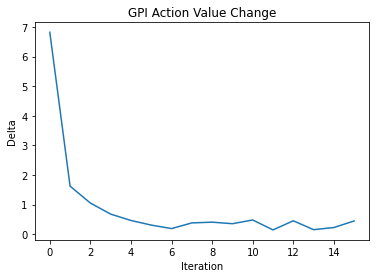

In [62]:
plt.plot(mcGPI.deltas)
plt.title('GPI Action Value Change')
plt.xlabel('Iteration')
plt.ylabel('Delta')
plt.savefig("gpi_action_value_graph.jpg")
plt.show()

<center><i>Figure 19: The change in the delta value, representing the mean difference of all action values between the start and end of each iteration</i></center>
<br>

In this run we've actually used the delta value to control the stopping of the GPI process (considering convergence to have been reached when delta is less than 0.04). The final policy is shown in figure 20 below:

<center><img src="images/part4/step_23.png"/></center>
<center><i>Figure 20: The policy formed at the final iteration of GPI, with a minimum delta of 0.04 used as the stopping criteria.</i></center>
<br>

This final policy defines a much shorter route from the entrance to the exit of the level. Additionally, the single action value of the start state has reduced from -45 in the initial policy down to -27 in the final policy. Since this value represents the return that can be expected when taking this action and, in the case of this environment where every action incurs a penalty of -1 for taking that action, you can see that we've dramatically reduced the amount of time that it will take Baby Robot to reach the exit.

However, things aren't perfect and this isn't the optimal policy for this level. For example, if you consider the bottom left-hand state, you can see that the final policy defines an action that would take Baby Robot North, when a shorter route to the exit would be to move East.

The best action hasn't been found due to a lack of sampling of the actions in this state. If you look at the number of first-visits to each action, as shown in Figure 21 below, you can see that the North action was only seen 3 times across the 23 episodes used for policy evaluation.

<br>
<br>
<center><img src="images/part4/step_23_action_visits.png"/></center>
<center><i>Figure 21: The first-visit count of the actions visited during the 23 iterations of GPI.</i></center>
<br>


There are a few reasons why this action was hardly ever visited:

* We defined a minimum delta value that stopped GPI before the optimal policy was found.
<br>
<br>
* We only ran a single episode for each policy evaluation step. Increasing the number of episodes would increase the accuracy of the action value estimates and increase the number of visits to each action.
<br>
<br>
* By default, Epsilon-Greedy follows the current deterministic policy. Although other actions are chosen at random to increase the exploration of the environment, remote states and actions are less likely to be visited. 
<br>

As mentioned previously, the fact that this state and its actions have been visited infrequently may not be a bad thing. Rather than visiting all states and actions an equal number of times, by concentrating on those that lead from the start state to the exit, we've reduced the time required to locate the most optimal trajectory through the maze. As usual it's the old exploration\exploitation trade-off.

---

# Summary

Monte Carlo methods use sampling to learn from experience. Over the course of multiple episodes they gradually build up an increasingly accurate picture of the environment. As a result, they can estimate state and action values without being given a model of the environment. 

During the policy evaluation step of Generalized Policy Iteration (GPI), by running complete episodes using the current policy, Monte Carlo methods can be used to form an average of the visited state-action values. 

To ensure that all states and actions are visited, exploration can be introduced in a number of ways, such as _exploring starts_, in which each new episode begins in a different state or action, or _epsilon-greedy_ policies where, by default, the action specified by the policy is taken, but with a probability '_epsilon_' a different, random, action is chosen.

If the policy is then improved by acting greedily with respect to these estimated values, the policy improvement theorem guarantees that the new policy will be as good or better than the previous policy. By repeating these steps of policy evaluation and improvement, Monte Carlo methods can be used to find the optimal policy.

# What's Next

So far we've only considered '**_on-policy_**' methods, in which a single policy is evaluated and improved. Going forwards we'll take a look at '**_off-policy_**' methods which employ more than one policy. For example, one policy can be used to explore and gather information, and a second policy, which is the policy that's actually used to negotiate the environment, is then created from this information.

We've also seen that unlike Dynamic Programming, Monte Carlo methods don't use the values from other states when updating their value estimates. In other words they don't 'bootstrap'. In the next article we'll look at **_Temporal-Difference (TD)_** learning which, like Monte Carlo, learns from experience but also employs bootstrapping when calculating its value estimates.

# References:

_["Reinforcement Learning: An Introduction"](http://www.incompleteideas.net/book/RLbook2020.pdf)_, Sutton & Barto (2018)
<br>
_["Lecture 4: Model-free Prediction"](https://www.youtube.com/watch?v=PnHCvfgC_ZA)_, David Silver

---

<center><img src="images/green_babyrobot_small.gif"/></center>

---